## Regression with Amazon SageMaker Linear Learner algorithm for Taxi ride fare prediction
_**Single machine training for regression with Amazon SageMaker Linear Learner algorithm**_

## Introduction

This notebook demonstrates the use of Amazon SageMaker’s implementation of the Linear Learner algorithm to train and host a regression model to predict taxi fare. This notebook uses the [New York City Taxi and Limousine Commission (TLC) Trip Record Data] (https://registry.opendata.aws/nyc-tlc-trip-records-pds/#) to train the model. We are not using the whole dataset from above but a small subset of the dataset to train our model here. You will download this subset of data in below steps.



---
## Setup


This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

Let's start by specifying:
1. The S3 buckets and prefixes that you want to use for training data and model data. This should be within the same region as the Notebook Instance, training, and hosting.
1. The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these. Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [1]:
# cell 02
import os
import boto3
import re
import sagemaker
import numpy as np

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [2]:
# cell 03
role = sagemaker.get_execution_role()
sess = sagemaker.Session()
region = boto3.Session().region_name

# S3 bucket for training data.
# this will create bucket like 'Sagemaker-<region>-<Your AccountId>'
data_bucket=sess.default_bucket()
data_prefix = "1p-notebooks-datasets/taxi/text-csv"


# S3 bucket for saving code and model artifacts.
output_bucket = data_bucket
output_prefix = "sagemaker/linear-learner-taxifare-regression"

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


In [3]:
# cell 04
import boto3
FILE_TRAIN = "nyc-taxi.csv"
# s3 = boto3.client("s3")
# s3.download_file(data_bucket, f"{FILE_TRAIN}", FILE_TRAIN)

import pandas as pd  # Read in csv and store in a pandas dataframe

# df = pd.read_csv(FILE_TRAIN, sep=",", encoding="latin1")
df = pd.read_csv(FILE_TRAIN, sep=",", encoding="latin1", names=["fare_amount","vendor_id","pickup_datetime","dropoff_datetime","passenger_count","trip_distance","pickup_longitude","pickup_latitude","rate_code","store_and_fwd_flag","dropoff_longitude","dropoff_latitude","payment_type","surcharge","mta_tax","tip_amount","tolls_amount","total_amount"])
print(df.head(5))

   fare_amount vendor_id pickup_datetime dropoff_datetime  passenger_count  \
0         18.0       CMT   01/11/12 1:18    01/11/12 1:35                1   
1         10.0       CMT   01/11/12 1:18    01/11/12 1:28                1   
2         35.5       CMT   01/11/12 1:18    01/11/12 2:16                1   
3          5.5       CMT   01/11/12 1:18    01/11/12 1:22                1   
4         10.5       CMT   01/11/12 1:18    01/11/12 1:27                1   

   trip_distance  pickup_longitude  pickup_latitude  rate_code  \
0            5.4        -73.984519        40.779776          1   
1            2.4        -73.996082        40.753302          1   
2            5.4        -73.970535        40.799144          1   
3            1.1        -73.956560        40.771124          1   
4            2.7        -73.959062        40.771722          1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude payment_type  \
0                  N         -73.947342         40.764681   

In [4]:
# cell 05
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 18 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   fare_amount         24998 non-null  float64
 1   vendor_id           24998 non-null  object 
 2   pickup_datetime     24998 non-null  object 
 3   dropoff_datetime    24998 non-null  object 
 4   passenger_count     24998 non-null  int64  
 5   trip_distance       24998 non-null  float64
 6   pickup_longitude    24998 non-null  float64
 7   pickup_latitude     24998 non-null  float64
 8   rate_code           24998 non-null  int64  
 9   store_and_fwd_flag  13789 non-null  object 
 10  dropoff_longitude   24998 non-null  float64
 11  dropoff_latitude    24998 non-null  float64
 12  payment_type        24998 non-null  object 
 13  surcharge           24998 non-null  float64
 14  mta_tax             24998 non-null  float64
 15  tip_amount          24998 non-null  float64
 16  toll

#### We have 18 features "fare_amount", "vendor_id", "pickup_datetime", "dropoff_datetime", "passenger_count", "trip_distance", "pickup_longitude", "pickup_latitude", "rate_code", "store_and_fwd_flag", "dropoff_longitude", "dropoff_latitude", "payment_type", "surcharge", "mta_tax", "tip_amount", "tolls_amount", "total_amount" in the dataset

Explore the dataset

col_0,% observations
vendor_id,
CMT,0.551604
VTS,0.448396


col_0,% observations
pickup_datetime,
01/11/12 0:34,0.00032
01/11/12 0:35,0.00068
01/11/12 10:22,0.00052
01/11/12 1:18,0.00136
01/11/12 1:19,0.00200
...,...
03/11/12 9:04,0.00144
03/11/12 9:05,0.00064
03/11/12 9:31,0.00140


col_0,% observations
dropoff_datetime,
01/11/12 0:36,0.00004
01/11/12 0:37,0.00008
01/11/12 0:38,0.00008
01/11/12 0:39,0.00004
01/11/12 0:40,0.00008
...,...
03/11/12 9:49,0.00020
03/11/12 9:50,0.00004
03/11/12 9:53,0.00004


col_0,% observations
store_and_fwd_flag,
N,0.980564
Y,0.019436


col_0,% observations
payment_type,
CRD,0.441635
CSH,0.554364
DIS,0.001080
NOC,0.002720
UNK,0.000200


,fare_amount,passenger_count,trip_distance,pickup_longitude,pickup_latitude,rate_code,dropoff_longitude,dropoff_latitude,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000,24998.000000
mean,12.351448,1.705496,3.273141,-72.571053,39.991996,1.040243,-72.525845,39.961398,0.364269,0.498200,1.098953,0.108989,14.421859
std,10.221020,1.310985,3.541442,10.067793,5.518109,0.322975,10.223284,5.621274,0.223349,0.029948,1.949909,0.777982,11.451719
min,2.500000,1.000000,0.000000,-76.089603,0.000000,1.000000,-76.089573,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
25%,6.500000,1.000000,1.270000,-73.987745,40.743390,1.000000,-73.988509,40.732185,0.000000,0.500000,0.000000,0.000000,8.000000
50%,9.500000,1.000000,2.180000,-73.975117,40.757237,1.000000,-73.974994,40.755305,0.500000,0.500000,0.000000,0.000000,11.000000
75%,14.000000,2.000000,3.850000,-73.957477,40.771164,1.000000,-73.954409,40.771601,0.500000,0.500000,1.700000,0.000000,16.500000
max,243.000000,6.000000,100.000000,0.000000,41.043487,5.000000,0.000000,43.216667,1.000000,0.500000,37.500000,17.900000,243.000000


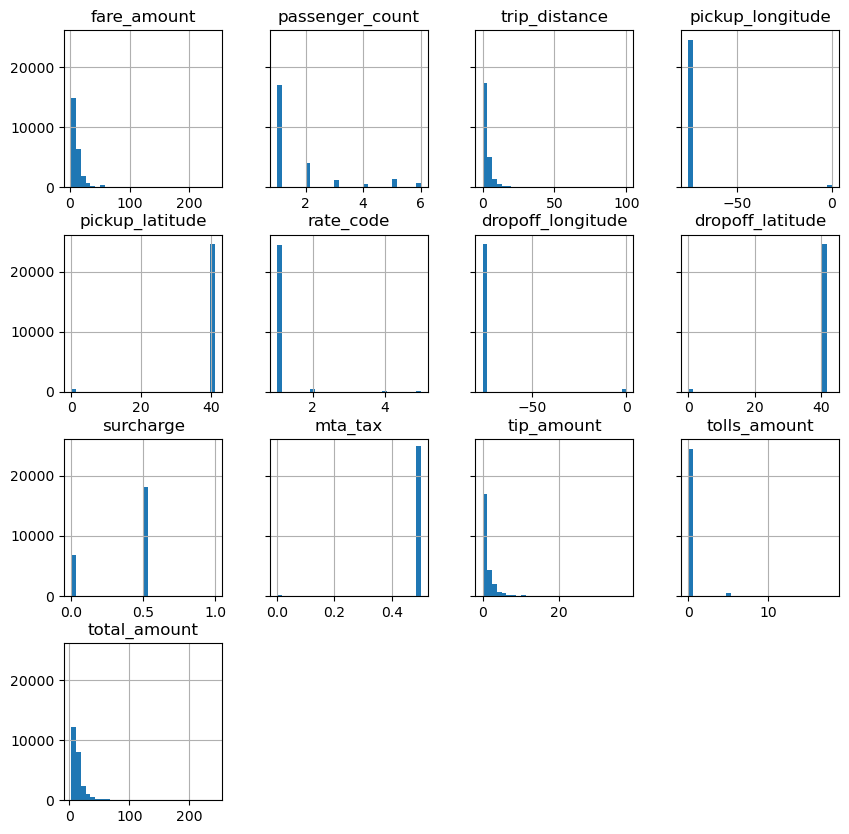

In [5]:
# cell 06
# Frequency tables for each categorical feature
for column in df.select_dtypes(include=['object']).columns:
    display(pd.crosstab(index=df[column], columns='% observations', normalize='columns'))

# Histograms for each numeric features
display(df.describe())
%matplotlib inline
hist = df.hist(bins=30, sharey=True, figsize=(10, 10))

#### As we can see that store_and_fwd_flg column doesn't have much variance in it ( as 98% of the column values are N and 2% are Y) hence this column won't have much impact on target variable ( fare_amount ). Also from our domain knowledge we can see that payment_type column value doesn't impact on trip fare hence we can drop both of these features from dataset

In [5]:
# cell 07
df = df.drop(['payment_type', 'store_and_fwd_flag'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        24998 non-null  float64
 1   vendor_id          24998 non-null  object 
 2   pickup_datetime    24998 non-null  object 
 3   dropoff_datetime   24998 non-null  object 
 4   passenger_count    24998 non-null  int64  
 5   trip_distance      24998 non-null  float64
 6   pickup_longitude   24998 non-null  float64
 7   pickup_latitude    24998 non-null  float64
 8   rate_code          24998 non-null  int64  
 9   dropoff_longitude  24998 non-null  float64
 10  dropoff_latitude   24998 non-null  float64
 11  surcharge          24998 non-null  float64
 12  mta_tax            24998 non-null  float64
 13  tip_amount         24998 non-null  float64
 14  tolls_amount       24998 non-null  float64
 15  total_amount       24998 non-null  float64
dtypes: float64(11), int64(

#### we can see that in the dataset there are 2 features 'pickup_datetime' and 'dropoff_datetime' which depict when ride started and when did it end. As we know that taxi fare is highly dependent on duration of the drive hence as part of feature engineering we will create a feature which will calculate ride duration using these  features

In [6]:
# cell 08
df['dropoff_datetime']= pd.to_datetime(df['dropoff_datetime'])
df['pickup_datetime']= pd.to_datetime(df['pickup_datetime'])
df['journey_time'] = (df['dropoff_datetime'] - df['pickup_datetime'])
df['journey_time'] = df['journey_time'].dt.total_seconds()
df['journey_time']

/tmp/ipykernel_97/2987868980.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['dropoff_datetime']= pd.to_datetime(df['dropoff_datetime'])
/tmp/ipykernel_97/2987868980.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['pickup_datetime']= pd.to_datetime(df['pickup_datetime'])


0        1020.0
1         600.0
2        3480.0
3         240.0
4         540.0
          ...  
24993     540.0
24994     420.0
24995     600.0
24996    1200.0
24997     420.0
Name: journey_time, Length: 24998, dtype: float64

#### after creation of 'journey_time feature' we can drop 'pickup_datetime' and 'dropoff_datetime' features

In [7]:
# cell 09
df = df.drop(['dropoff_datetime', 'pickup_datetime'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        24998 non-null  float64
 1   vendor_id          24998 non-null  object 
 2   passenger_count    24998 non-null  int64  
 3   trip_distance      24998 non-null  float64
 4   pickup_longitude   24998 non-null  float64
 5   pickup_latitude    24998 non-null  float64
 6   rate_code          24998 non-null  int64  
 7   dropoff_longitude  24998 non-null  float64
 8   dropoff_latitude   24998 non-null  float64
 9   surcharge          24998 non-null  float64
 10  mta_tax            24998 non-null  float64
 11  tip_amount         24998 non-null  float64
 12  tolls_amount       24998 non-null  float64
 13  total_amount       24998 non-null  float64
 14  journey_time       24998 non-null  float64
dtypes: float64(12), int64(2), object(1)
memory usage: 2.9+ MB


#### As we can see that vedor_id is still a categorical feature and we need to chage it to float ( using dummuies 0) so that dataset can be passed to Liner learner algorithm

In [8]:
# cell 10
df = pd.get_dummies(df, dtype=float)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24998 entries, 0 to 24997
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fare_amount        24998 non-null  float64
 1   passenger_count    24998 non-null  int64  
 2   trip_distance      24998 non-null  float64
 3   pickup_longitude   24998 non-null  float64
 4   pickup_latitude    24998 non-null  float64
 5   rate_code          24998 non-null  int64  
 6   dropoff_longitude  24998 non-null  float64
 7   dropoff_latitude   24998 non-null  float64
 8   surcharge          24998 non-null  float64
 9   mta_tax            24998 non-null  float64
 10  tip_amount         24998 non-null  float64
 11  tolls_amount       24998 non-null  float64
 12  total_amount       24998 non-null  float64
 13  journey_time       24998 non-null  float64
 14  vendor_id_CMT      24998 non-null  float64
 15  vendor_id_VTS      24998 non-null  float64
dtypes: float64(14), int64(

#### Split the dataframe in train, test and validation

In [9]:
# cell 11
import numpy as np

train_data, validation_data, test_data = np.split(df.sample(frac=1, random_state=1729), [int(0.7 * len(df)), int(0.9 * len(df))])
train_data.to_csv('train.csv', header=False, index=False)
validation_data.to_csv('validation.csv', header=False, index=False)
test_data.to_csv('test.csv', header=False, index=False)

/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [10]:
# cell 12
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(data_prefix, 'train/train.csv')).upload_file('train.csv')
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(data_prefix, 'validation/validation.csv')).upload_file('validation.csv')
boto3.Session().resource('s3').Bucket(data_bucket).Object(os.path.join(data_prefix, 'test/test.csv')).upload_file('test.csv')


---
Let us prepare the handshake between our data channels and the algorithm. To do this, we need to create the `sagemaker.session.s3_input` objects from our [data channels](https://sagemaker.readthedocs.io/en/v1.2.4/session.html#). These objects are then put in a simple dictionary, which the algorithm consumes. Notice that here we use a `content_type` as `text/csv` for the pre-processed file in the data_bucket. We use two channels here one for training and the second one for validation. The testing samples from above will be used on the prediction step.

In [11]:
# cell 13
# creating the inputs for the fit() function with the training and validation location
s3_train_data = f"s3://{data_bucket}/{data_prefix}/train"
print(f"training files will be taken from: {s3_train_data}")

s3_validation_data = f"s3://{data_bucket}/{data_prefix}/validation"
print(f"validtion files will be taken from: {s3_validation_data}")

s3_test_data = f"s3://{data_bucket}/{data_prefix}/test"
print(f"test files will be taken from: {s3_test_data}")

output_location = f"s3://{output_bucket}/{output_prefix}/output"
print(f"training artifacts output location: {output_location}")

# generating the session.s3_input() format for fit() accepted by the sdk
train_data = sagemaker.inputs.TrainingInput(
    s3_train_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)
validation_data = sagemaker.inputs.TrainingInput(
    s3_validation_data,
    distribution="FullyReplicated",
    content_type="text/csv",
    s3_data_type="S3Prefix",
    record_wrapping=None,
    compression=None,
)

training files will be taken from: s3://sagemaker-us-east-1-313975053939/1p-notebooks-datasets/taxi/text-csv/train
validtion files will be taken from: s3://sagemaker-us-east-1-313975053939/1p-notebooks-datasets/taxi/text-csv/validation
test files will be taken from: s3://sagemaker-us-east-1-313975053939/1p-notebooks-datasets/taxi/text-csv/test
training artifacts output location: s3://sagemaker-us-east-1-313975053939/sagemaker/linear-learner-taxifare-regression/output


## Training the Linear Learner model

First, we retrieve the image for the Linear Learner Algorithm according to the region.

Then we create an [estimator from the SageMaker Python SDK](https://sagemaker.readthedocs.io/en/stable/api/training/estimators.html) using the Linear Learner container image and we setup the training parameters and hyperparameters configuration.


In [12]:
# cell 14
# getting the linear learner image according to the region
from sagemaker.image_uris import retrieve

container = retrieve("linear-learner", boto3.Session().region_name, version="1")
print(container)

382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [13]:
%%time
import boto3
import sagemaker
from time import gmtime, strftime

sess = sagemaker.Session()

job_name = "linear-learner-taxifare-regression-" + strftime("%H-%M-%S", gmtime())
print("Training job", job_name)

linear = sagemaker.estimator.Estimator(
    container,
    role,
    input_mode="File",
    instance_count=1,
    instance_type="ml.m4.xlarge",
    output_path=output_location,
    sagemaker_session=sess,
)

linear.set_hyperparameters(
    epochs=16,
    wd=0.01,
    loss="absolute_loss",
    predictor_type="regressor",
    normalize_data=True,
    optimizer="adam",
    mini_batch_size=1000,
    lr_scheduler_step=100,
    lr_scheduler_factor=0.99,
    lr_scheduler_minimum_lr=0.0001,
    learning_rate=0.1,
)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
Training job linear-learner-taxifare-regression-15-26-32
CPU times: user 332 ms, sys: 39.8 ms, total: 372 ms
Wall time: 470 ms


---
After configuring the Estimator object and setting the hyperparameters for this object. The only remaining thing to do is to train the algorithm. The following cell will train the algorithm. Training the algorithm involves a few steps. Firstly, the instances that we requested while creating the Estimator classes are provisioned and are setup with the appropriate libraries. Then, the data from our channels are downloaded into the instance. Once this is done, the training job begins. The provisioning and data downloading will take time, depending on the size of the data. Therefore it might be a few minutes before we start getting data logs for our training jobs. The data logs will also print out Mean Average Precision (mAP) on the validation data, among other losses, for every run of the dataset once or one epoch. This metric is a proxy for the quality of the algorithm.

Once the job has finished a "Job complete" message will be printed. The trained model can be found in the S3 bucket that was setup as output_path in the estimator.

In [14]:
%%time
linear.fit(inputs={"train": train_data, "validation": validation_data}, job_name=job_name)

INFO:sagemaker:Creating training-job with name: linear-learner-taxifare-regression-15-26-32


2023-12-05 15:26:38 Starting - Starting the training job......
2023-12-05 15:27:21 Starting - Preparing the instances for training.........
2023-12-05 15:28:51 Downloading - Downloading input data...
2023-12-05 15:29:26 Training - Downloading the training image......
2023-12-05 15:30:37 Training - Training image download completed. Training in progress....Docker entrypoint called with argument(s): train
Running default environment configuration script
[12/05/2023 15:30:55 INFO 140686851315520] Reading default configuration from /opt/amazon/lib/python3.8/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', '

## Set up hosting for the model

Once the training is done, we can deploy the trained model as an Amazon SageMaker real-time hosted endpoint. This will allow us to make predictions (or inference) from the model. Note that we don't have to host on the same insantance (or type of instance) that we used to train. Training is a prolonged and compute heavy job that require a different of compute and memory requirements that hosting typically do not. We can choose any type of instance we want to host the model. In our case we chose the ml.m4.xlarge instance to train, but we choose to host the model on the less expensive cpu instance, ml.c4.xlarge. The endpoint deployment can be accomplished as follows:

In [15]:
%%time
# creating the endpoint out of the trained model
linear_predictor = linear.deploy(initial_instance_count=1, instance_type="ml.c4.xlarge")
print(f"\ncreated endpoint: {linear_predictor.endpoint_name}")

INFO:sagemaker:Creating model with name: linear-learner-2023-12-05-15-32-29-160
INFO:sagemaker:Creating endpoint-config with name linear-learner-2023-12-05-15-32-29-160
INFO:sagemaker:Creating endpoint with name linear-learner-2023-12-05-15-32-29-160


-------!
created endpoint: linear-learner-2023-12-05-15-32-29-160
CPU times: user 83.4 ms, sys: 9.25 ms, total: 92.6 ms
Wall time: 4min 2s


## Inference

Now that the trained model is deployed at an endpoint that is up-and-running, we can use this endpoint for inference. To do this, we are going to configure the [predictor object](https://sagemaker.readthedocs.io/en/v1.2.4/predictors.html) to parse contents of type text/csv and deserialize the reply received from the endpoint to json format.


In [16]:
# cell 18
# configure the predictor to accept to serialize csv input and parse the reposne as json
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer

linear_predictor.serializer = CSVSerializer()
linear_predictor.deserializer = JSONDeserializer()

---
We then use the test file containing the records of the data that we kept to test the model prediction. By running below cell multiple times we are selecting random sample from the testing samples to perform inference with.

In [17]:
%%time
import json
from itertools import islice
import math
import struct
import boto3
import random

# downloading the test file from data_bucket
FILE_TEST = "test.csv"
s3 = boto3.client("s3")
s3.download_file(data_bucket, f"{data_prefix}/test/{FILE_TEST}", FILE_TEST)

# getting testing sample from our test file
test_data = [l for l in open(FILE_TEST, "r")]
sample = random.choice(test_data).split(",")
actual_fare = sample[0]
payload = sample[1:]  # removing actual age from the sample
payload = ",".join(map(str, payload))
print('payload: ', payload, type(payload))
# Invoke the predicor and analyise the result
result = linear_predictor.predict(payload)
print('Result:', result)
# extracting the prediction value
result = round(float(result["predictions"][0]["score"]), 2)


accuracy = str(round(100 - ((abs(float(result) - float(actual_fare)) / float(actual_fare)) * 100), 2))
print(f"Actual fare: {actual_fare}\nPrediction: {result}\nAccuracy: {accuracy}")

payload:  1,1.1,-73.978357,40.763963,1,-73.978397,40.752407,0.5,0.5,0.0,0.0,7.5,300.0,1.0,0.0
 <class 'str'>
Result: {'predictions': [{'score': 6.288797378540039}]}
Actual fare: 6.5
Prediction: 6.29
Accuracy: 96.77
CPU times: user 81 ms, sys: 0 ns, total: 81 ms
Wall time: 355 ms


In [ ]:
# cell 20
